In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import random
import math
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LinearRegression

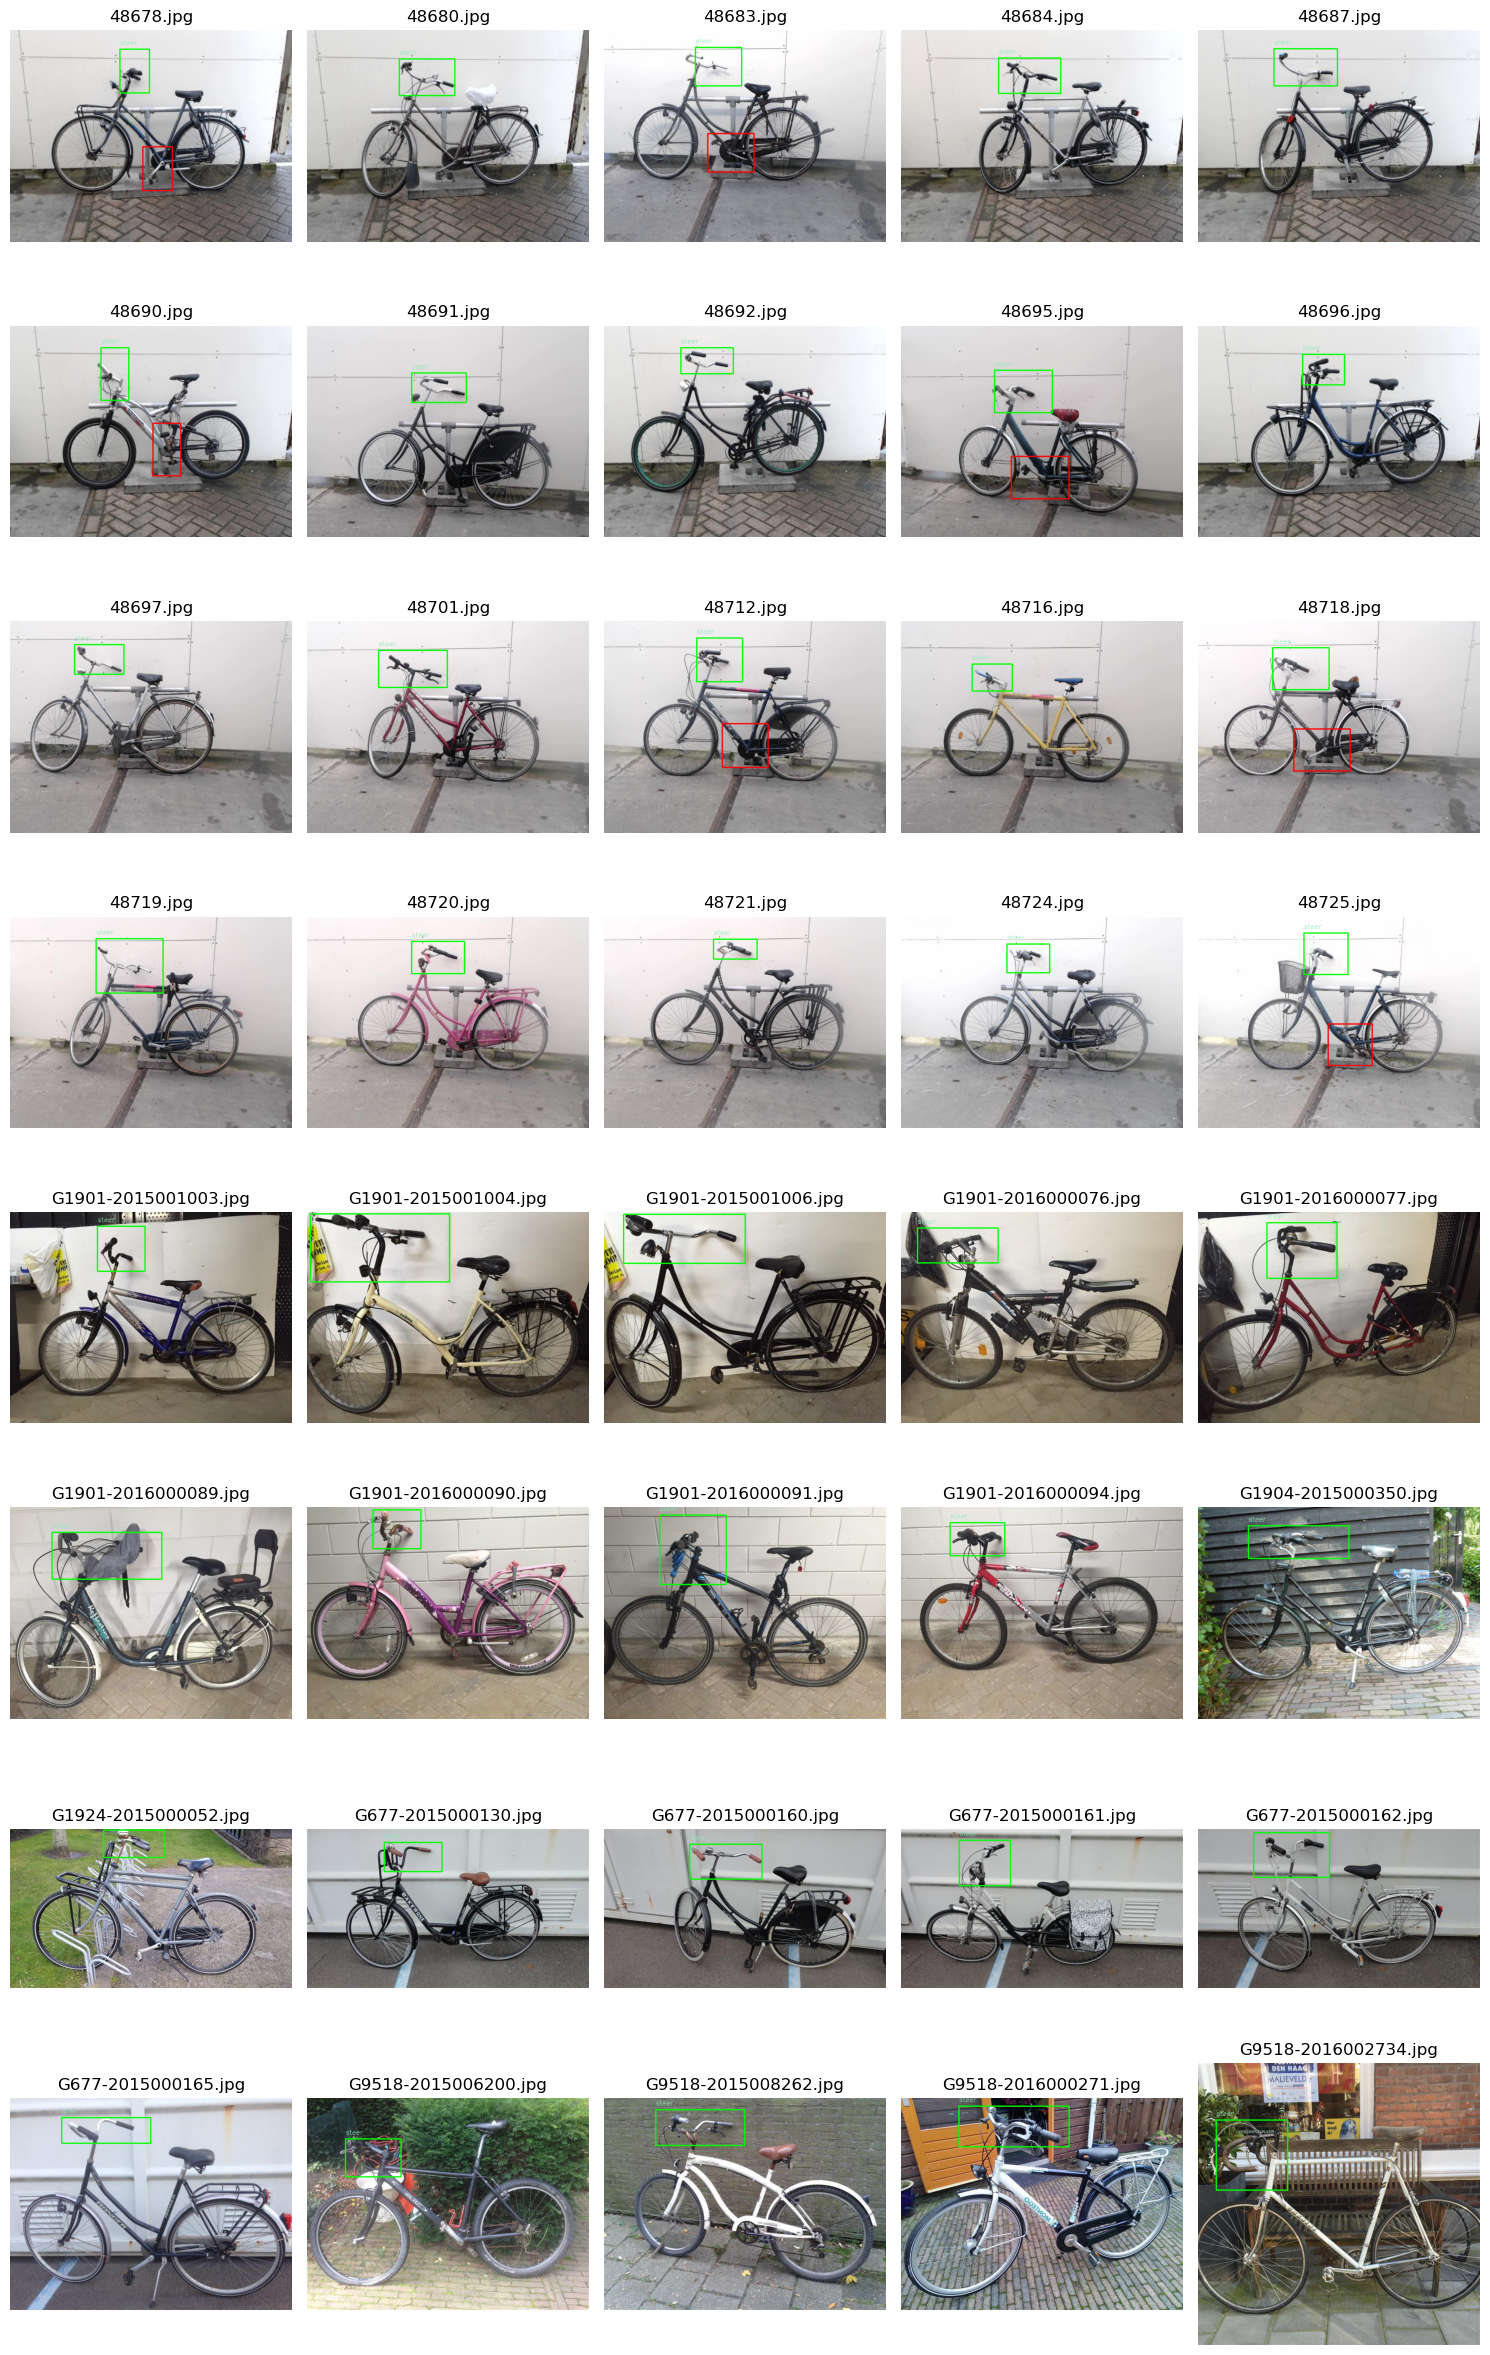

In [ ]:
json_file = '../../data/raw/train_annotations.json'
image_directory = '../../data/images'

with open(json_file, 'r') as f:
    annotations = json.load(f)

image_filenames = sorted(annotations.keys())
selected_filenames = image_filenames[:20] + image_filenames[-20:]
all_parts = {part for ann in annotations.values() for part in ann.get("parts", {})}

random.seed(42)
part_colors = {part: tuple(random.randint(0, 255) for _ in range(3)) for part in all_parts}


def refine_with_grabcut(image, bbox, iterations=5, shrink_limit=0.7):
    mask = np.zeros(image.shape[:2], np.uint8)
    rect = (bbox["left"], bbox["top"], bbox["width"], bbox["height"])
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    try:
        cv2.grabCut(image, mask, rect, bgd_model, fgd_model, iterations, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        coords = cv2.findNonZero(mask2)

        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            w = max(w, int(bbox["width"] * shrink_limit))
            h = max(h, int(bbox["height"] * shrink_limit))
        
            return {"left": x, "top": y, "width": w, "height": h}
        
    except Exception as e:
        print(f"GrabCut error: {e}")

    return bbox
# Resizing of the mudguards
def resize_bounding_box_to_top_right(bbox, factor=1.0):
    new_w = int(bbox["width"] * factor)
    new_h = int(bbox["height"] * factor)
    new_left = bbox["left"] + bbox["width"] - new_w
    return {"left": new_left, "top": bbox["top"], "width": new_w, "height": new_h}

# Used for fitting bounding boxes into other bounding boxes (steer and handles)
def clamp_box(x, y, w, h, box_left, box_top, box_right, box_bottom):
    x = max(box_left, min(x, box_right - w))
    y = max(box_top, min(y, box_bottom - h))
    return x, y


def adjust_boxes(image, part_boxes, visible_parts, use_grabcut):
    adjusted_boxes = {}
    steer_bbox = part_boxes.get("steer")
    front_wheel_bbox = part_boxes.get("front_wheel")
    back_handle_bbox = part_boxes.get("back_handle")
    adjusted_steer_bbox = steer_bbox.copy() if steer_bbox else None

    steer_is_wide = False

    # Checks if the steering wheel is wide compared to the front wheel
    if steer_bbox and front_wheel_bbox:
        if abs(steer_bbox["width"] - front_wheel_bbox["width"]) < 0.1 * front_wheel_bbox["width"]:
            steer_is_wide = True

    for name, bbox in part_boxes.items():
        if visible_parts and name not in visible_parts:
            continue

        adjusted_bbox = bbox.copy()

        if name in ["front_mudguard", "back_mudguard"]:
            adjusted_bbox = resize_bounding_box_to_top_right(bbox, factor=0.8)

        # Adjusts location of the steer in relation to the back_handle
        elif name == "steer" and back_handle_bbox:
            steer_center = (bbox["left"] + bbox["width"] / 2, bbox["top"] + bbox["height"] / 2)
            back_center = (back_handle_bbox["left"] + back_handle_bbox["width"] / 2,
                           back_handle_bbox["top"] + back_handle_bbox["height"] / 2)
            distance = math.dist(steer_center, back_center)
            threshold = 2 * math.hypot(back_handle_bbox["width"], back_handle_bbox["height"])

            if distance > threshold:

                if steer_is_wide:
                    offset = -30
                else:
                    offset = -5

                adjusted_bbox["left"] = int(back_center[0] - bbox["width"] / 2 + offset)
                adjusted_bbox["top"] = int(back_center[1] - bbox["height"] / 2)

            adjusted_steer_bbox = adjusted_bbox

        # Checks the position and size of the front_handle and front_handbreak compared to the steer
        elif name in ["front_handle", "front_handbreak"] and steer_is_wide and adjusted_steer_bbox and back_handle_bbox:
            target_size = {
                "width": back_handle_bbox["width"],
                "height": back_handle_bbox["height"]
            }

            sl, st = adjusted_steer_bbox["left"], adjusted_steer_bbox["top"]
            sr, sb = sl + adjusted_steer_bbox["width"], st + adjusted_steer_bbox["height"]

            if name == "front_handle":
                raw_left, raw_top = sl, st
            else:
                handle_box = adjusted_boxes.get("front_handle")
                raw_left = handle_box["left"] if handle_box else sl
                raw_top = (handle_box["top"] + handle_box["height"] + 5) if handle_box else (st + target_size["height"] + 5)

            clamped_left, clamped_top = clamp_box(raw_left, raw_top, target_size["width"], target_size["height"], sl, st, sr, sb)

            adjusted_bbox = {
                "left": clamped_left,
                "top": clamped_top,
                **target_size
            }

        # Adjusts the position of the back_hand_break to be below the back_handle
        elif name == "back_hand_break" and back_handle_bbox:
            adjusted_bbox = {
                "left": back_handle_bbox["left"],
                "top": back_handle_bbox["top"] + back_handle_bbox["height"] - 5,
                "width": back_handle_bbox["width"],
                "height": back_handle_bbox["height"]
            }

        if use_grabcut and name not in [
            "front_mudguard", "back_mudguard", "saddle",
            "front_wheel", "back_wheel", "front_pedal", "back_pedal", "steer"
        ]:
            adjusted_bbox = refine_with_grabcut(image, adjusted_bbox)

        adjusted_boxes[name] = adjusted_bbox

    return adjusted_boxes


def draw_boxes(image_path, annotation, use_grabcut=True, visible_parts=None):
    image = cv2.imread(image_path)
    
    if image is None:
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    part_boxes = {name: data["absolute_bounding_box"] for name, data in annotation.get("parts", {}).items()}
    adjusted_boxes = adjust_boxes(image, part_boxes, visible_parts, use_grabcut)

    for name, orig_bbox in part_boxes.items():

        if visible_parts and name not in visible_parts:
            continue
    
        adj_bbox = adjusted_boxes.get(name)

        if not adj_bbox:
            continue

        cv2.rectangle(image, (orig_bbox["left"], orig_bbox["top"]),
                      (orig_bbox["left"] + orig_bbox["width"], orig_bbox["top"] + orig_bbox["height"]),
                      (255, 0, 0), 2)
        cv2.rectangle(image, (adj_bbox["left"], adj_bbox["top"]),
                      (adj_bbox["left"] + adj_bbox["width"], adj_bbox["top"] + adj_bbox["height"]),
                      (0, 255, 0), 2)
        cv2.putText(image, name, (adj_bbox["left"], adj_bbox["top"] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, part_colors.get(name, (255, 255, 255)), 1)

    return image

def plot_images(images, titles, cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 3 * rows))

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_image(filename, annotations, image_directory, visible_parts=None):
    path = os.path.join(image_directory, filename)
    image = draw_boxes(path, annotations[filename], use_grabcut=True, visible_parts=visible_parts)
    return image, filename

def process_images_in_parallel(filenames, annotations, image_directory, visible_parts=None):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, fn, annotations, image_directory, visible_parts) for fn in filenames]
        results = [f.result() for f in futures]

    images, titles = zip(*filter(lambda x: x[0] is not None, results))
    return images, titles


visible_parts = ["steer"]
images, titles = process_images_in_parallel(selected_filenames, annotations, image_directory, visible_parts)
plot_images(images, titles)